Class distribution before resampling: 1    248
0    152
Name: class, dtype: int64


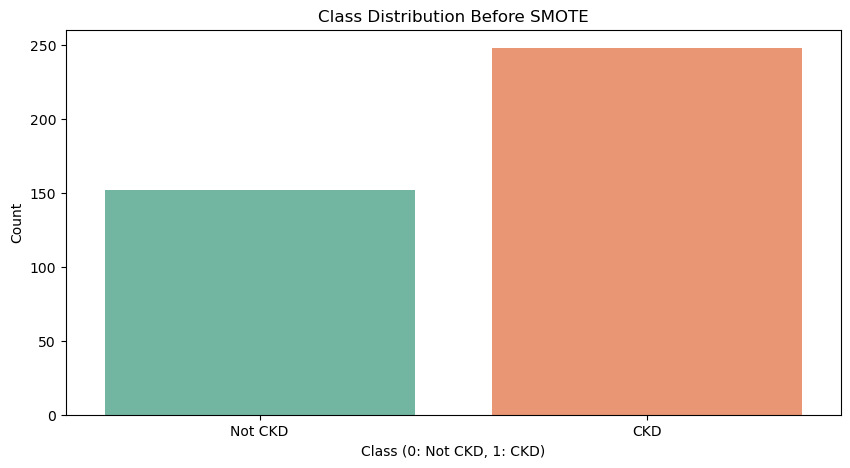

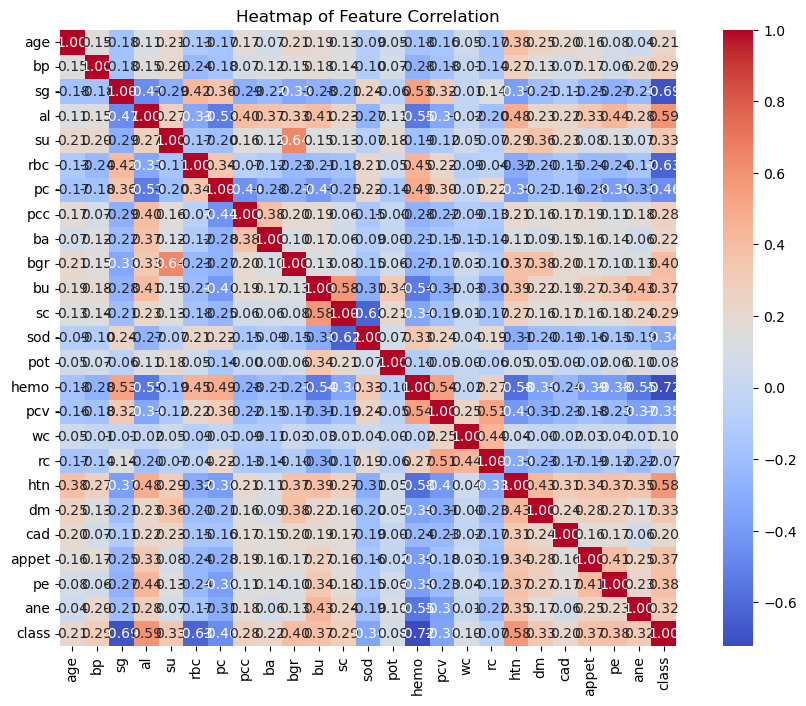

Selected features based on ANOVA F-test:
Index(['sg', 'al', 'rbc', 'pc', 'bgr', 'bu', 'hemo', 'htn', 'appet', 'pe'], dtype='object')


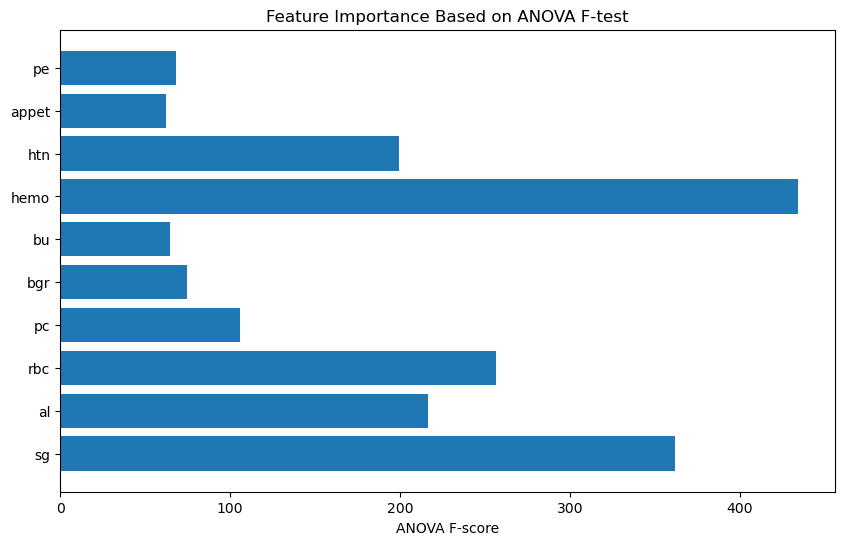

Class distribution after resampling: 1    248
0    248
Name: class, dtype: int64


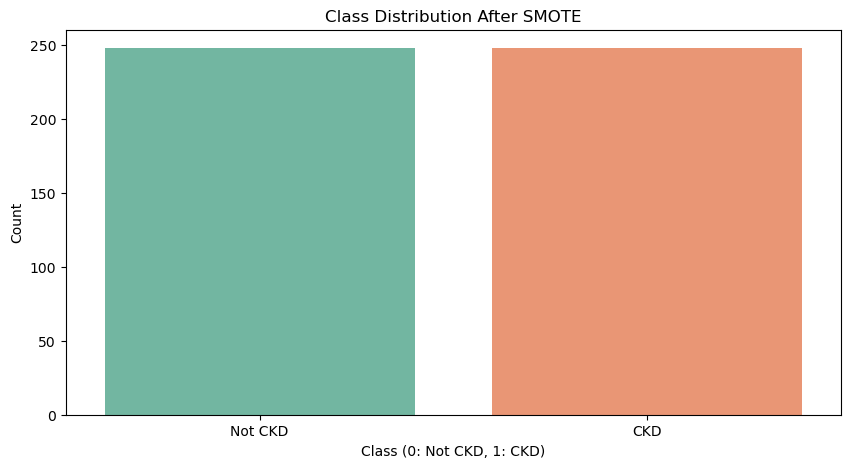

Logistic Regression:
[[72  0]
 [ 2 75]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.97      0.99        77

    accuracy                           0.99       149
   macro avg       0.99      0.99      0.99       149
weighted avg       0.99      0.99      0.99       149


Random Forest Classifier:
[[70  2]
 [ 0 77]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        72
           1       0.97      1.00      0.99        77

    accuracy                           0.99       149
   macro avg       0.99      0.99      0.99       149
weighted avg       0.99      0.99      0.99       149

Logistic Regression Cross-validation scores: [0.95       0.98989899 0.95959596 1.         0.93939394]
Random Forest Cross-validation scores: [0.95       0.97979798 1.         1.         0.98989899]


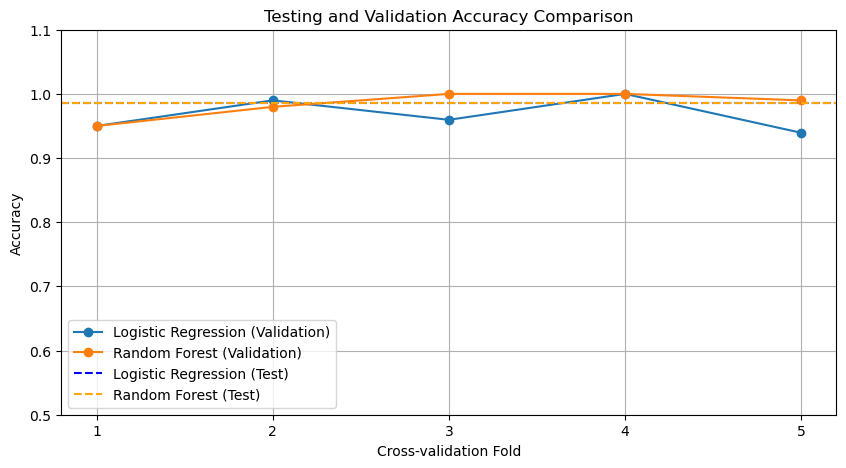

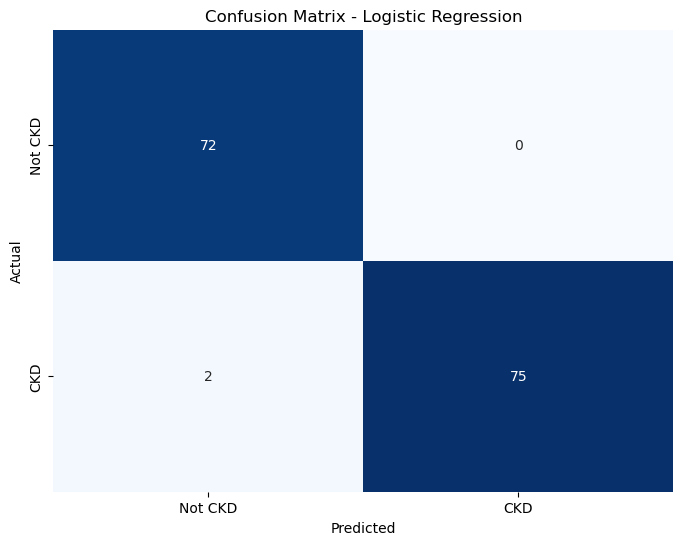

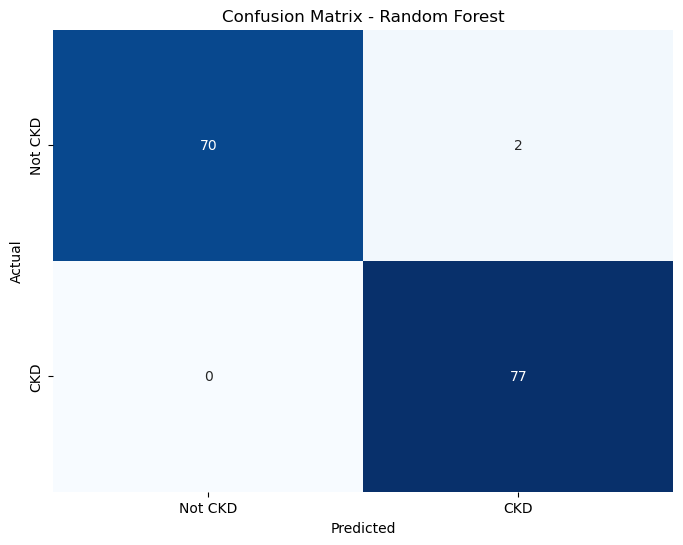

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
ckd_data = pd.read_csv('kidney_disease.csv')


# Select relevant columns
columns = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
           'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']
ckd_data = ckd_data[columns]

# Rename 'classification' column for consistency
ckd_data.rename(columns={'classification': 'class'}, inplace=True)

# Encode the target variable (ckd or not ckd)
ckd_data['class'] = ckd_data['class'].map({'ckd': 1, 'notckd': 0})

# Handle missing values
numeric_cols = ckd_data.select_dtypes(include=['float64', 'int64']).columns
ckd_data[numeric_cols] = ckd_data[numeric_cols].fillna(ckd_data[numeric_cols].mean())

# Encode categorical features
categorical_cols = ckd_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'class':
        le = LabelEncoder()
        ckd_data[col] = le.fit_transform(ckd_data[col].astype(str))

# Ensure 'class' is of type integer
ckd_data['class'] = ckd_data['class'].astype(int)

# Check the distribution of classes
print("Class distribution before resampling:", ckd_data['class'].value_counts())

# Plot class distribution before SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(data=ckd_data, x='class', palette='Set2')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class (0: Not CKD, 1: CKD)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not CKD', 'CKD'])
plt.show()

# Plotting the heatmap of correlation
plt.figure(figsize=(12, 8))
correlation = ckd_data.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.title('Heatmap of Feature Correlation')
plt.show()

# Split the data into features (X) and target (y)
X = ckd_data.drop(columns='class')
y = ckd_data['class']

# Apply ANOVA F-test for feature selection
k = 10  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features based on ANOVA F-test:")
print(selected_features)

# Plotting feature scores from ANOVA
plt.figure(figsize=(10, 6))
plt.barh(selected_features, selector.scores_[selector.get_support()])
plt.xlabel('ANOVA F-score')
plt.title('Feature Importance Based on ANOVA F-test')
plt.show()

# Apply SMOTE to handle class imbalance on selected features
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Check the distribution of classes after SMOTE
print("Class distribution after resampling:", pd.Series(y_resampled).value_counts())

# Plot class distribution after SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_resampled, palette='Set2')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class (0: Not CKD, 1: CKD)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not CKD', 'CKD'])
plt.show()

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Feature scaling for numeric data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model 1: Logistic Regression
logreg = LogisticRegression(max_iter=200, solver='liblinear', C=1.0)  
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Model 2: Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=30,         
    max_depth=8,             
    min_samples_split=5,     
    min_samples_leaf=3,      
    max_features='sqrt',     
    random_state=42
)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Evaluation Metrics for Logistic Regression
print("Logistic Regression:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

# Evaluation Metrics for Random Forest
print("\nRandom Forest Classifier:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Cross-validation for Logistic Regression
logreg_cv_scores = cross_val_score(logreg, X_resampled, y_resampled, cv=5)
print(f"Logistic Regression Cross-validation scores: {logreg_cv_scores}")

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_clf, X_resampled, y_resampled, cv=5)
print(f"Random Forest Cross-validation scores: {rf_cv_scores}")

# Plotting the accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), logreg_cv_scores, marker='o', label='Logistic Regression (Validation)')
plt.plot(range(1, 6), rf_cv_scores, marker='o', label='Random Forest (Validation)')
plt.axhline(y=accuracy_score(y_test, y_pred_logreg), color='blue', linestyle='--', label='Logistic Regression (Test)')
plt.axhline(y=accuracy_score(y_test, y_pred_rf), color='orange', linestyle='--', label='Random Forest (Test)')
plt.title('Testing and Validation Accuracy Comparison')
plt.xlabel('Cross-validation Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, 6))
plt.ylim(0.5, 1.1)
plt.legend()
plt.grid()
plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plot_confusion_matrix(cm_logreg, title='Confusion Matrix - Logistic Regression')

# Plot confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, title='Confusion Matrix - Random Forest')
